I'll follow classification process with https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [1]:
import time
import numpy as np

import torch
from torch import nn
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

_____

In [2]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [3]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # embedding + averaging
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

_____

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('.data/DBpedia/train.csv')
test_df = pd.read_csv('.data/DBpedia/test.csv')
valid_df = pd.read_csv('.data/DBpedia/valid.csv')

In [7]:
label_dict = {v:k for k,v in enumerate(train_df['l3'].unique())}

In [8]:
train_iter = list(zip(train_df['l3'].map(lambda x : label_dict[x]).tolist(), train_df['text'].tolist()))
valid_iter = list(zip(valid_df['l3'].map(lambda x : label_dict[x]).tolist(), valid_df['text'].tolist()))
test_iter = list(zip(test_df['l3'].map(lambda x : label_dict[x]).tolist(), test_df['text'].tolist()))

____

In [9]:
tokenizer = get_tokenizer('basic_english')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu"); print(device)

# set vocab size
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

cuda:1


In [10]:
# load nn.Module object
num_class = len(set([label for (label, text) in train_iter])); print(num_class)
vocab_size = len(vocab); print(vocab_size)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

219
628321


In [11]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [12]:
class TemporalDataset(Dataset):
    def __init__(self, mem, transform=None):
        self._data = mem

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]

In [13]:
train_dataset = TemporalDataset(train_iter)
valid_dataset = TemporalDataset(valid_iter)
test_dataset = TemporalDataset(test_iter)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

### generate out of distribution

____

In [15]:
EPOCHS = 50

In [ ]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

____

In [17]:
from cycler import cycler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [18]:
model.fc = Identity()

In [19]:
def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

In [20]:
label_mapper = {v:k for k,v in label_dict.items()}

In [21]:
# test dataset (same dataset)
embeddings, labels = get_all_embeddings(test_dataloader, model)
tsne_embeddings = TSNE(2).fit_transform(embeddings)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

dict_ = dict()

for l in torch.unique(labels) : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    dict_[l] = np.nanmean(cs_mat)

pd.DataFrame.from_dict(dict_, orient='index').describe()

,0
count,219.000000
mean,0.793000
std,0.070921
min,0.492417
25%,0.747307
50%,0.802006
75%,0.844523
max,0.953866


____

# Full visualization

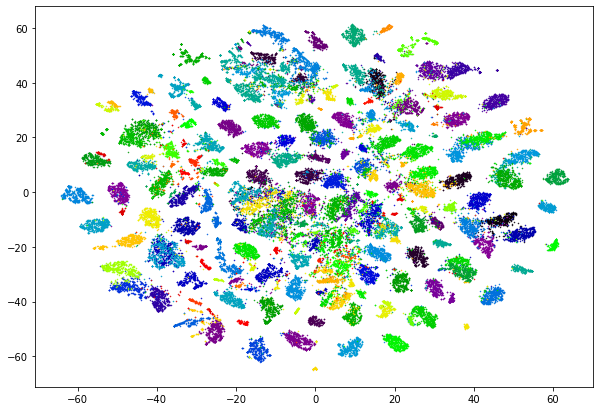

In [23]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=1, label=str_label)
# plt.legend()
plt.show()

# Imbalanced visualization

In [24]:
small_labels = [label_dict[l] for l in train_df.l3.value_counts().tail(30).index]

In [25]:
markersize = 5

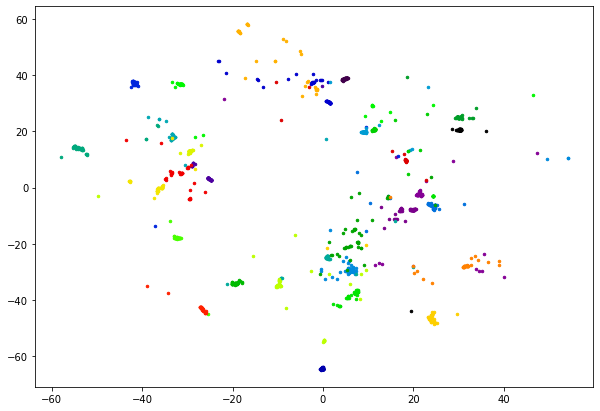

In [26]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) \
                                          for i in np.linspace(0, 0.9, len(small_labels))]))
for i in small_labels :
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize, label=str_label)
# plt.legend()
plt.show()

In [63]:
small_labels = [label_dict[l] for l in train_df.l3.value_counts().tail(30).index]

In [27]:
mem = []

for l in small_labels : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    mem.append(np.nanmean(cs_mat))

(array([4., 1., 5., 4., 4., 4., 4., 2., 1., 1.]),
 array([0.6759729 , 0.7037622 , 0.7315514 , 0.7593407 , 0.78712994,
        0.81491923, 0.8427085 , 0.87049776, 0.89828706, 0.9260763 ,
        0.9538656 ], dtype=float32),
 <BarContainer object of 10 artists>)

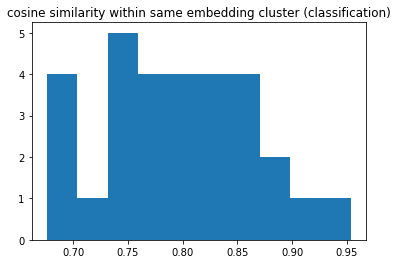

In [28]:
plt.title("cosine similarity within same embedding cluster (classification)")
plt.hist(mem)

In [29]:
cs_mat = cosine_similarity(embeddings[np.in1d(labels, small_labels)])
cs_mat[np.tril_indices_from(cs_mat)] = np.nan

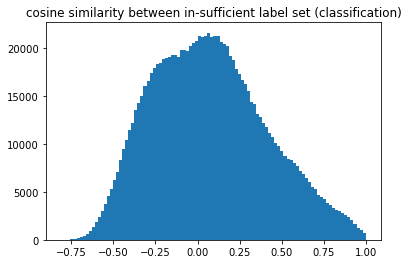

In [30]:
plt.title("cosine similarity between in-sufficient label set (classification)")
_ = plt.hist(cs_mat[np.isfinite(cs_mat)], bins=100)

In [31]:
cs_mat = cosine_similarity(embeddings[~np.in1d(labels, small_labels)], \
                  embeddings[np.in1d(labels, small_labels)].mean(0).reshape(1,-1))


In [32]:
cs_mat = cosine_similarity(embeddings[~np.in1d(labels, small_labels)], \
                  embeddings[np.in1d(labels, small_labels)].mean(0).reshape(1,-1))

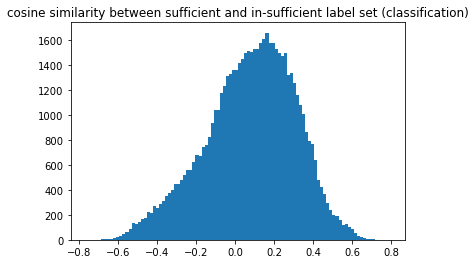

In [33]:
plt.title("cosine similarity between sufficient and in-sufficient label set (classification)")
_ = plt.hist(cs_mat[np.isfinite(cs_mat)], bins=100)

# Out of distribution visualization

In [64]:
cat_labels = torch.cat([labels, out_labels * 1000])

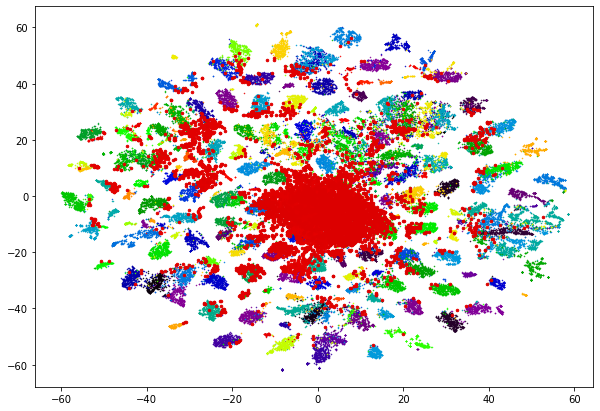

In [67]:
label_set = np.unique(cat_labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) \
                                          for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes) :
    idx = cat_labels == label_set[i]
    markersize = 5 if label_set[i] >= 1000 else 1
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize)
# plt.legend()
plt.show()

In [70]:
train_df.l3.unique()

array(['Senator', 'Album', 'Mountain', 'AcademicJournal',
       'HistoricBuilding', 'Reptile', 'MilitaryUnit', 'Judge',
       'ChessPlayer', 'TradeUnion', 'Musical', 'Insect', 'Town',
       'SupremeCourtOfTheUnitedStatesCase', 'TennisPlayer',
       'SpeedwayRider', 'Publisher', 'GolfPlayer', 'HorseRider',
       'ShoppingMall', 'Road', 'MilitaryPerson', 'Election',
       'ArtistDiscography', 'OfficeHolder', 'IceHockeyPlayer', 'Diocese',
       'Library', 'Lake', 'Monarch', 'Conifer', 'Bridge', 'Dam',
       'BasketballPlayer', 'Glacier', 'NationalFootballLeagueSeason',
       'RugbyPlayer', 'Single', 'Mayor', 'VoiceActor', 'SoccerManager',
       'Economist', 'Skier', 'HandballPlayer', 'Saint', 'RecordLabel',
       'AmateurBoxer', 'HollywoodCartoon', 'Theatre', 'Legislature',
       'ComicsCreator', 'GolfTournament', 'MilitaryConflict',
       'CollegeCoach', 'AnimangaCharacter', 'OlympicEvent', 'Convention',
       'University', 'BadmintonPlayer', 'NCAATeamSeason', 'VideoGame',


In [71]:
label_mapper

{'World': 1, 'Sports': 2, 'Business': 3, 'Sci/Tec': 4}